<a href="https://colab.research.google.com/github/tramyynt/Techlabs/blob/master/Pickshare_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install geopandas
import pandas as pd
import json
import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.graph_objects as go
import geopandas as gpd
import geopy
plt.style.use('seaborn')

from google.colab import drive
%matplotlib inline

In [16]:
users = pd.read_json('/pickshare_users.json')
# users.head(5)
packages = pd.read_json('/pickshare_packages.json')
packages.head(5)

,senderCompanyName,city,_owner
0,Amazon,Dortmund,Björn
1,Zoo Royal,Berlin,Pia
2,ABOUTYOU,Dortmund,Björn
3,Test,Berlin,VTest
4,notebooksbilliger.de,Dortmund,Björn


In [28]:
print(packages['_owner'].describe())
print(packages['city'].describe())
print(users['firstName'].describe())
print(users['city'].describe())

count        3408
unique        100
top       Karsten
freq          252
Name: _owner, dtype: object
count       3362
unique        39
top       Berlin
freq        2345
Name: city, dtype: object
count      257
unique     209
top       Test
freq         5
Name: firstName, dtype: object
count        257
unique        61
top       Berlin
freq         102
Name: city, dtype: object


In [29]:
print(packages['senderCompanyName'].describe())

count       3408
unique      1002
top       Amazon
freq        1055
Name: senderCompanyName, dtype: object


1. Cluster geospatial data to know where we should put a depot
2. Cluster based on their total numbers of oders.

**Data Preprocessing**

In [30]:
def  cleaning_text(df, col):
  df.loc[df[col].str.contains('berlin', case=False, regex=False), col] = 'Berlin'
  df.loc[df[col].str.contains('dortmund', case=False, regex=False), col] = 'Dortmund'
  df.loc[df[col].str.contains('Potsdam', case=False, regex=False), col] = 'Potsdam'
  df.loc[df[col].str.contains('Dusseldorf', case=False, regex=False), col] = 'Düsseldorf'
  df.loc[df[col].str.contains('Regensburg', case=False, regex=False), col] = 'Regensburg'
  df.loc[df[col].str.contains('Moenchengladbach', case = False, regex = False), col] = 'Mönchengladbach'
  df.loc[df[col].str.contains('Bad Hersfeld', case = False, regex = False), col] = 'Bad Hersfeld'
  df.loc[df[col].str.contains('Viersen', case = False, regex = False), col] = 'Viersen'
  df.loc[df[col].str.contains('Münster', case = False, regex = False), col] = 'Münster'
  df.loc[df[col].str.contains('mönchengladbach', case = False, regex = False), col] = 'Mönchengladbach'
  df.loc[df[col].str.contains('Wetzlar', case = False, regex = False), col] = 'Wetzlar'
  df.loc[df[col].str.contains('München', case = False, regex = False), col] = 'München'
  return df

In [31]:
#packages
#packages.isna().sum()
packages = packages[packages.city.notna()].reset_index(drop=True) #remove missing values

#cleaning text
packages = cleaning_text(packages, 'city')

In [32]:
#users
users = users[users.city.notna()].reset_index(drop = True)

users = cleaning_text(users,'city')

In [33]:
#get city list of Germany and check if a city belongs to the list, otherwise remove it. Refer : https://moduliertersingvogel.de/2017/09/03/german-cities-list/
from bs4 import BeautifulSoup
import requests
class CityList:
    def __init__(self):
        self.__countries={
            'BY':'Bayern',
            'BW':'Baden-Württemberg',
            'NW':'Nordrhein-Westfalen',
            'HE':'Hessen',
            'SN':'Sachsen',
            'NI':'Niedersachsen',
            'RP':'Rheinland-Pfalz',
            'TH':'Thüringen',
            'BB':'Brandenburg',
            'ST':'Sachsen-Anhalt',
            'MV':'Mecklenburg-Vorpommern',
            'SH':'Schleswig-Holstein',
            'SL':'Saarland',
            'HB':'Bremen',
            'BE':'Berlin',
            'HH':'Hamburg'
        }
    def retrieveGermanList(self):
        r = requests.get('https://de.wikipedia.org/wiki/Liste_der_St%C3%A4dte_in_Deutschland')
        soup = BeautifulSoup(r.content, "html5lib")
        cities={}
        tables=soup.find_all('table')
        for t in tables:
            lis=t.find_all('dd')
            for l in lis:
                # All countries are in brackets after the city name.
                # Some cities are listed like: SN, Landeshauptstadt
                countryShort=None
                additional=l.contents[1].split('(')[1].split(')')[0].strip()
                if ',' in additional:
                    countryShort=additional.split(',')[0]
                else:
                    countryShort=additional
                cities[l.find('a').contents[0]]=self.__countries[countryShort]
                
        return cities

city_list = CityList().retrieveGermanList()
users = users[users['city'].isin(city_list.keys())]
packages = packages[packages['city'].isin(city_list.keys())]    

In [34]:
users_per_city = users['city'].value_counts().to_frame().reset_index(drop = False)
users_per_city.columns = ['city', 'number_users']
users_per_city['federal'] = users_per_city['city'].apply(lambda x: city_list[x])
users_per_city['percentage_user'] = users_per_city['number_users']*100/users_per_city['number_users'].sum()
users_per_city

,city,number_users,federal,percentage_user
0,Berlin,115,Berlin,48.728814
1,Dortmund,36,Nordrhein-Westfalen,15.254237
2,Mönchengladbach,24,Nordrhein-Westfalen,10.169492
3,Wetzlar,12,Hessen,5.084746
4,Münster,10,Nordrhein-Westfalen,4.237288
5,Potsdam,5,Brandenburg,2.118644
6,Bad Hersfeld,4,Hessen,1.694915
7,Regensburg,3,Bayern,1.271186
8,Düsseldorf,3,Nordrhein-Westfalen,1.271186
9,Stade,2,Niedersachsen,0.847458


In [35]:
packages_per_city = packages['city'].value_counts().to_frame().reset_index(drop=False)
packages_per_city.columns = ['city','num_packages']
packages_per_city['federal'] = packages_per_city['city'].apply(lambda x: city_list[x]) 
packages_per_city

,city,num_packages,federal
0,Berlin,2768,Berlin
1,Dortmund,306,Nordrhein-Westfalen
2,Wetzlar,52,Hessen
3,Münster,50,Nordrhein-Westfalen
4,Regensburg,38,Bayern
5,Mönchengladbach,26,Nordrhein-Westfalen
6,Potsdam,22,Brandenburg
7,Düsseldorf,18,Nordrhein-Westfalen
8,Grevenbroich,5,Nordrhein-Westfalen
9,Grünberg,4,Hessen


In [36]:
packages_per_city['percentage'] = packages_per_city['num_packages']*100/packages_per_city['num_packages'].sum()

In [37]:
packages_per_city

,city,num_packages,federal,percentage
0,Berlin,2768,Berlin,83.827983
1,Dortmund,306,Nordrhein-Westfalen,9.267111
2,Wetzlar,52,Hessen,1.574803
3,Münster,50,Nordrhein-Westfalen,1.514234
4,Regensburg,38,Bayern,1.150818
5,Mönchengladbach,26,Nordrhein-Westfalen,0.787402
6,Potsdam,22,Brandenburg,0.666263
7,Düsseldorf,18,Nordrhein-Westfalen,0.545124
8,Grevenbroich,5,Nordrhein-Westfalen,0.151423
9,Grünberg,4,Hessen,0.121139


In [38]:
pack_per_city = packages_per_city.copy()
pack_per_city = pack_per_city.drop(columns = 'federal')

**Exploratory Data Analysis**
1. Number of packages per city
2. Number of users per city
3. Number of packages per sender

**1. Cities have the most orders**

In [39]:
#get Geman map
plz_ort = pd.read_csv('/zuordnung_plz_ort.csv',sep=',', dtype={'plz': str})
plz_ort.drop('osm_id', axis=1, inplace=True)
plz_ort.head(5)
#!unzip /content/drive/MyDrive/Techlabs/plz-gebiete.shp.zip  -d /content/drive/MyDrive/Techlabs

,ort,plz,bundesland
0,Aach,78267,Baden-Württemberg
1,Aach,54298,Rheinland-Pfalz
2,Aachen,52062,Nordrhein-Westfalen
3,Aachen,52064,Nordrhein-Westfalen
4,Aachen,52066,Nordrhein-Westfalen


In [40]:
plz_shape_df = gpd.read_file('/plz-gebiete.shp', dtype={'plz': str})
plz_shape_df.head()

,plz,note,geometry
0,52538,"52538 Gangelt, Selfkant","POLYGON ((5.86632 51.05110, 5.86692 51.05124, ..."
1,47559,47559 Kranenburg,"POLYGON ((5.94504 51.82354, 5.94580 51.82409, ..."
2,52525,"52525 Waldfeucht, Heinsberg","POLYGON ((5.96811 51.05556, 5.96951 51.05660, ..."
3,52074,52074 Aachen,"POLYGON ((5.97486 50.79804, 5.97495 50.79809, ..."
4,52531,52531 Ãbach-Palenberg,"POLYGON ((6.01507 50.94788, 6.03854 50.93561, ..."


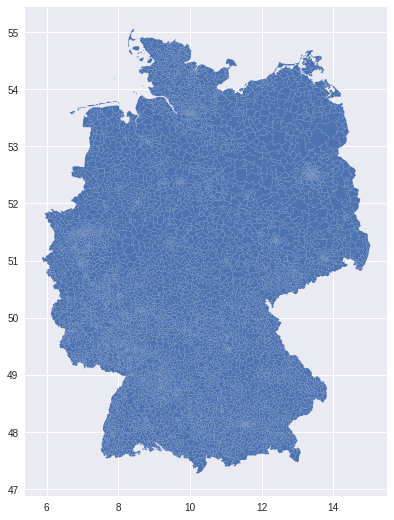

In [54]:
plz_shape_df["geometry"].plot(figsize=(9,9))
plt.show()

In [42]:
plz_merged = pd.merge(left= plz_shape_df,right= plz_ort, on = 'plz', how = 'left')

In [43]:
plz_merged = plz_merged.rename(columns={'ort':'city'})

In [44]:
#get longitude and latitude. refer: https://medium.com/analytics-vidhya/how-to-generate-lat-and-long-coordinates-of-city-without-using-apis-25ebabcaf1d5
from  geopy.geocoders import Nominatim
geolocator = Nominatim()
def get_geocode(city):
  country ="Germany"
  loc = geolocator.geocode(city+','+ country)
  return loc.longitude, loc.latitude

/usr/local/lib/python3.7/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


In [45]:
packages_per_city['geo'] = packages_per_city['city'].apply(lambda x : get_geocode(x))
packages_per_city['longitude'] = packages_per_city['city'].apply(lambda x : get_geocode(x)[0])
packages_per_city['latitude'] = packages_per_city['city'].apply(lambda x : get_geocode(x)[1])

In [46]:
# get zipcodes
def get_zipcode(df, geolocator, lat_field, lon_field):
    location = geolocator.reverse((df[lat_field], df[lon_field]))
    return location.raw['address']['postcode']


geolocator = geopy.Nominatim(user_agent='my-application')
packages_per_city['plz'] = packages_per_city.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='latitude', lon_field='longitude')
packages_per_city.head(5)

,city,num_packages,federal,percentage,geo,longitude,latitude,plz
0,Berlin,2768,Berlin,83.827983,"(13.3888599, 52.5170365)",13.388860,52.517037,10117
1,Dortmund,306,Nordrhein-Westfalen,9.267111,"(7.4652789, 51.5142273)",7.465279,51.514227,44137
2,Wetzlar,52,Hessen,1.574803,"(8.5074406, 50.5525346)",8.507441,50.552535,35578
3,Münster,50,Nordrhein-Westfalen,1.514234,"(7.6251879, 51.9625101)",7.625188,51.962510,48143
4,Regensburg,38,Bayern,1.150818,"(12.0974869, 49.0195333)",12.097487,49.019533,93047


In [47]:
#use dict for city and geometry
top_cities = pd.Series(packages_per_city.geo.values,index=packages_per_city.city).to_dict()
top_cities

{'Bad Hersfeld': (9.7068481, 50.8681341),
 'Berlin': (13.3888599, 52.5170365),
 'Bremen': (8.8071646, 53.0758196),
 'Dortmund': (7.4652789, 51.5142273),
 'Düsseldorf': (6.7763137, 51.2254018),
 'Essen': (7.0158171, 51.4582235),
 'Grevenbroich': (6.5835365, 51.0905783),
 'Grünberg': (8.9603407, 50.5913238),
 'Iserlohn': (7.6999713, 51.3746778),
 'Mönchengladbach': (6.4353641, 51.1946983),
 'Münster': (7.6251879, 51.9625101),
 'Potsdam': (13.0591397, 52.4009309),
 'Regensburg': (12.0974869, 49.0195333),
 'Reinbek': (10.2511001, 53.5098898),
 'Stade': (9.475438, 53.599794),
 'Viersen': (6.3905476, 51.2562118),
 'Wetzlar': (8.5074406, 50.5525346)}

In [48]:
#merge
merged_pack_city = pd.merge(
    left=plz_merged, 
    right=pack_per_city, 
    on='city',
    how='left'
)
merged_pack_city['percentage'] = merged_pack_city['percentage'].fillna(0)

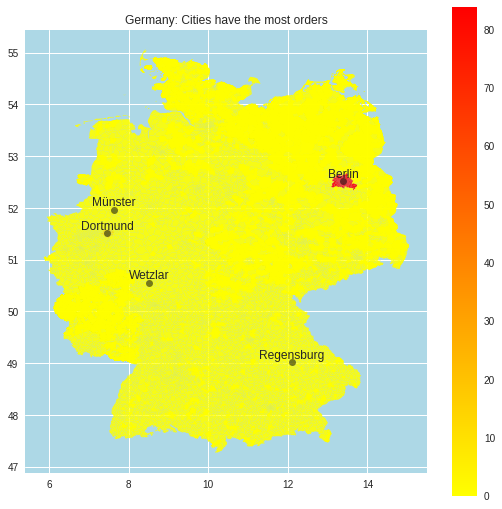

In [59]:
#plot a map
fig,ax = plt.subplots(figsize = (9,9))

merged_pack_city.plot(
    ax=ax, 
    column='percentage', 
    categorical=False, 
    legend=True, 
    cmap='autumn_r',
    alpha=0.9,
)
for c in top_cities.keys():
    if merged_pack_city[merged_pack_city["city"] == c].iloc[0]["percentage"] < 1 :
      continue;

    ax.text(
        x=top_cities[c][0], 
        y=top_cities[c][1] + 0.08, 
        s=c, 
        fontsize=12,
        ha='center', 
    )

    ax.plot(
        top_cities[c][0], 
        top_cities[c][1], 
        marker='o',
        c='black', 
        alpha=0.5
    )
    
ax.set(
    title='Germany: Cities have the most orders', 
    aspect=1.3, 
    facecolor='lightblue'
);
plt.show()


**2. Cities have the most users**

In [60]:
merged_user_city = pd.merge(
    left=plz_merged, 
    right=users_per_city, 
    on='city',
    how='left'
)
merged_user_city['percentage_user'] = merged_user_city['percentage_user'].fillna(0)

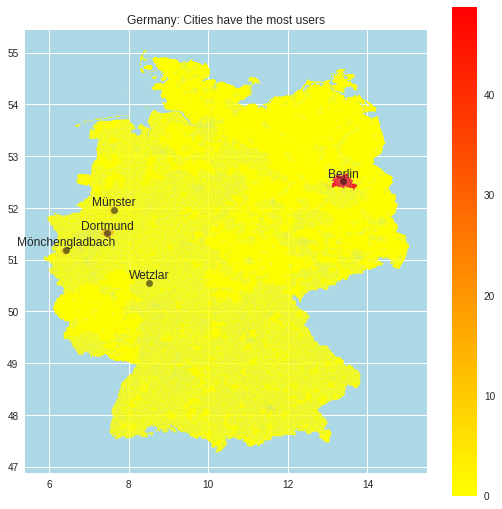

In [66]:
fig,ax = plt.subplots(figsize = (9,9))

merged_user_city.plot(
    ax=ax, 
    column='percentage_user', 
    categorical=False, 
    legend=True, 
    cmap='autumn_r',
    alpha=0.9,
)
for c in top_cities.keys():
    if merged_user_city[merged_user_city["city"] == c].iloc[0]["percentage_user"] < 4 :
      continue;

    ax.text(
        x=top_cities[c][0], 
        y=top_cities[c][1] + 0.08, 
        s=c, 
        fontsize=12,
        ha='center', 
    )

    ax.plot(
        top_cities[c][0], 
        top_cities[c][1], 
        marker='o',
        c='black', 
        alpha=0.5
    )
    
ax.set(
    title='Germany: Cities have the most users', 
    aspect=1.3, 
    facecolor='lightblue'
);
plt.show()

As we can see, some cities have many users but not many orders and vice versa, which means it might be our depot distribution is not optimal yet.


**3. Number of packages per sender**

In [67]:
print(packages['senderCompanyName'].describe())

count       3302
unique      1002
top       Amazon
freq        1033
Name: senderCompanyName, dtype: object


In [86]:

packages_per_sender = packages['senderCompanyName'].value_counts().to_frame().reset_index(drop=False)
packages_per_sender.columns = ['sender','num_packages']
packages_per_sender['federal'] = packages_per_city['city'].apply(lambda x: city_list[x]) 
packages_per_sender.head(10)

,sender,num_packages,federal
0,Amazon,1033,Berlin
1,Default,311,Nordrhein-Westfalen
2,Privat,127,Hessen
3,zalando,79,Nordrhein-Westfalen
4,Otto,68,Bayern
5,dm,61,Nordrhein-Westfalen
6,Tchibo,57,Brandenburg
7,ABOUTYOU,30,Nordrhein-Westfalen
8,Conrad,27,Nordrhein-Westfalen
9,Rossmann,26,Hessen


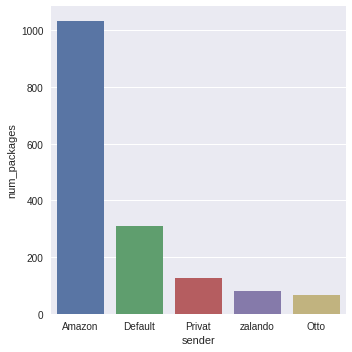

In [85]:
sns.catplot(x="sender",
            y="num_packages",
            data=packages_per_sender.head(5),
            kind="bar")
plt.show()